<a href="https://colab.research.google.com/github/hyakuroume/Generative_AI/blob/develop/compressing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q genaibook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 146.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.1 MB/s eta 0:00:00


## データの準備

In [2]:
from datasets import load_dataset

# MINSITデータセットのロード
mnist = load_dataset("mnist")
mnist

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
# 28pixel*28pixelの手書き数字の画像
mnist["train"]["image"][0]

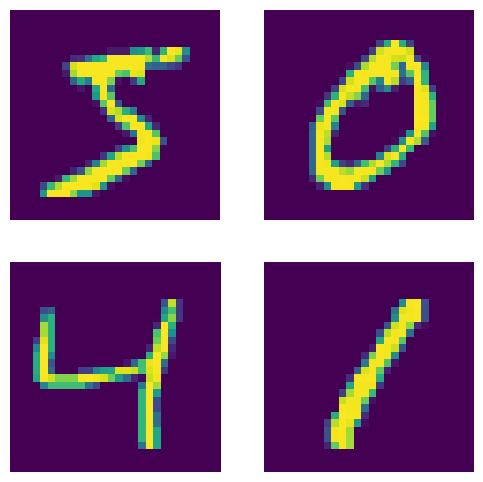

In [3]:
# 高解像度で表示
from genaibook.core import show_images

show_images(mnist["train"]["image"][:4])

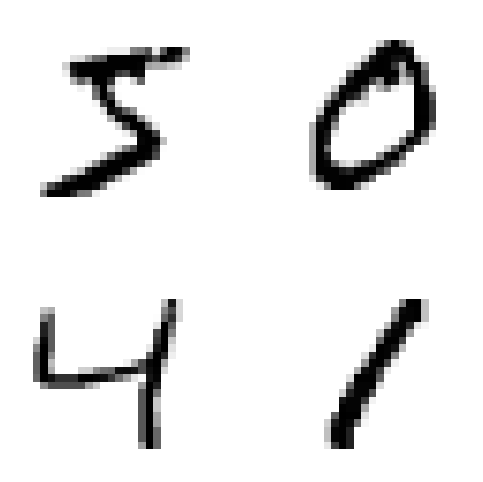

In [4]:
# 白黒で表示
import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray_r"
show_images(mnist["train"]["image"][:4])

In [5]:
from torchvision import transforms

def mnist_to_tensor(samples):
    """
    mnistデータセットを受け取り、PyTorchテンソルに変換する

    Args:
        samples (dict): mnistデータセットのサンプル

    Returns:
        dict: PyTorchテンソルに変換されたサンプル
    """
    t = transforms.ToTensor()
    samples["image"] = [t(image) for image in samples["image"]]
    return samples

In [6]:
# データをPyTorchテンソルに変換し、訓練データセットをシャッフル
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [7]:
# データの確認(0~1の範囲になっているか)
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

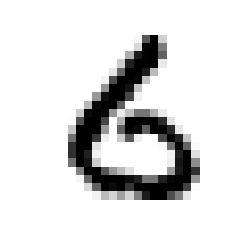

In [ ]:
show_images(mnist["train"]["image"][0])

In [8]:
# DataLoaderの作成
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

## エンコーダーのモデリング

In [9]:
from torch import nn

def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        ),

        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [25]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # バッチの次元数を保持したまま平坦化
        x = self.linear(x.flatten(start_dim=1))
        return x

In [26]:
# サイズの確認
mnist["train"]["image"][0].shape

torch.Size([1, 28, 28])

In [27]:
in_channels = 1

x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [ ]:
encoded

tensor([[ 2.4254e-02, -4.3659e-04,  9.5598e-04, -2.8590e-02, -5.5946e-03,
         -2.0903e-02, -1.6663e-02, -1.6515e-03, -1.5799e-02,  1.2399e-02,
          2.5017e-02,  1.4055e-03, -2.6913e-03,  2.0417e-02, -2.0797e-02,
         -2.4902e-06]], grad_fn=<AddmmBackward0>)

In [28]:
# バッチに対応できているか確認
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels)(batch)

batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

## デコーダー

In [29]:
def conv_transposed_block(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=0,
        with_act=True
):
    """
    転地畳み込み

    Args:
        in_channels (int): 入力チャネル数
        out_channels (int): 出力チャネル数

    Return:
        nn.Sequential: 転地畳み込み層のレイヤーブロック
    """

    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]

    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())

    return nn.Sequential(*modules)

In [30]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.linear = nn.Linear(16, 1024 * 4 * 4)
        self.t_conv1 = conv_transposed_block(1024, 512)
        self.t_conv2 = conv_transposed_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transposed_block(256, out_channels, output_padding=1)

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))

        x = self.t_conv1(x)
        x = self.t_conv2(x)
        x = self.t_conv3(x)

        return x

In [ ]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([1, 1, 28, 28])

## 訓練

In [31]:
class AutoEncoder(nn.Module):
    """
    エンコーダとデコーダーを直列につないだモデル
    """
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [32]:
# モデルの定義
model = AutoEncoder(1)

In [ ]:
# 各レイヤーのパラメータ数や出力形状の確認
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [33]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange
from genaibook.core import get_device

In [34]:
# エポック数と学習率の定義
num_epochs = 10
lr = 1e-4

In [35]:
device = get_device()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

In [ ]:
losses = []

for _ in (progress := trange(num_epochs, desc="Training")):
    for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
        batch = batch.to(device)

        # モデルの予測
        preds = model(batch)

        # 予測と元画像の比較
        loss = F.mse_loss(preds, batch)

        # 損失を表示し、描画用に保存
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        losses.append(loss.item())

        # 損失に基づいてモデルのパラメータを更新
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


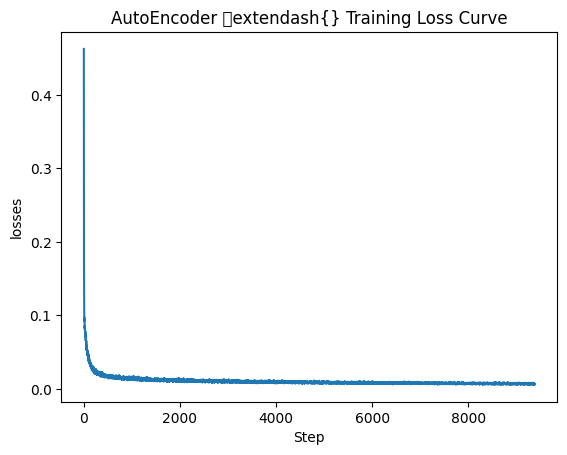

In [ ]:
# 損失曲線の可視化
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("losses")
plt.title("AutoEncoder \textendash{} Training Loss Curve")
plt.show()

In [53]:
# 評価用のデータローダーの作成
eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

In [ ]:
# 評価モードにして予測
model.eval()

with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

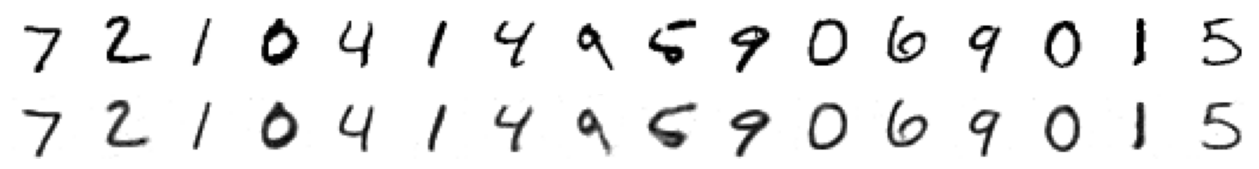

In [ ]:
# 元の画像と予測画像の比較
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

## 潜在空間の探索

- 潜在空間の次元をハイパーパラメータに含める
- 畳み込み層をnn.Sequentialにまとめる
- 活性化関数をシグモイド関数に変更

In [36]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )

        self.linear = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = self.linear(x.reshape(bs, -1))
        return x

In [37]:
class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super().__init__()

        self.linear = nn.Linear(latent_dims, 1024*4*4)
        self.t_conv_layers = nn.Sequential(
            conv_transposed_block(1024, 512),
            conv_transposed_block(512, 256, output_padding=1),
            conv_transposed_block(256, out_channels, output_padding=1, with_act=False),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))
        x = self.t_conv_layers(x)
        x = self.sigmoid(x)
        return x

In [38]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [41]:
def train(model, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

    model.train()
    losses = []

    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
            batch = batch.to(device)

            # モデルに渡して別の画像セットを取得
            preds = model(batch)

            # 予測結果と元画像を比較
            loss = F.mse_loss(preds, batch)

            # 損失を表示し、描画用に保存
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())

            # 損失に基づいてモデルのパラメータを表示
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

    return losses

In [42]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

In [65]:
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

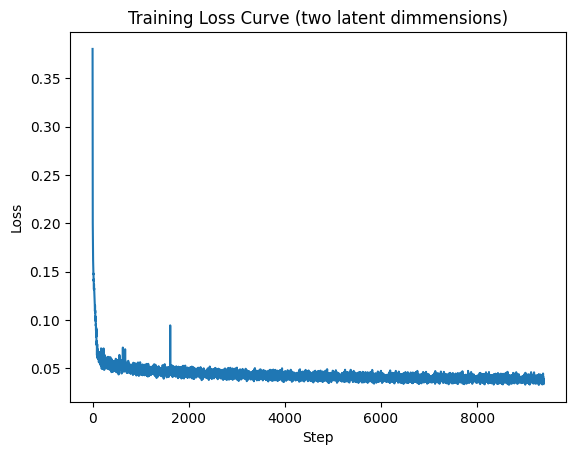

In [66]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimmensions)")
plt.show()

In [67]:
ae_model.eval()

with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

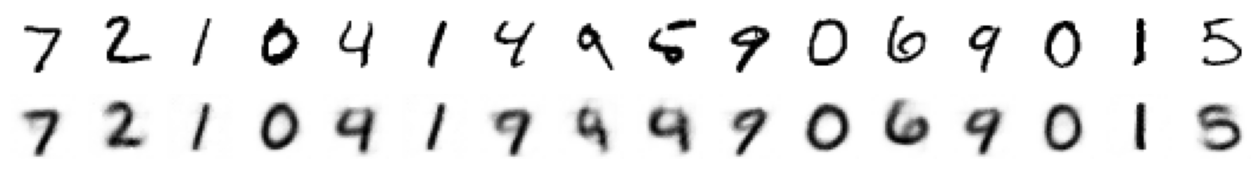

In [68]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

## 潜在空間の可視化

In [39]:
images_labels_dataloader = DataLoader(mnist["test"], batch_size=512)

In [43]:
import pandas as pd

df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(iter(images_labels_dataloader), total=len(images_labels_dataloader)):
    encoded = ae_model.encode(batch["image"].to(device)).cpu()
    new_items = {
        "x": [t.item() for t in encoded[:, 0]],
        "y": [t.item() for t in encoded[:, 1]],
        "label": batch["label"]
    }

    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

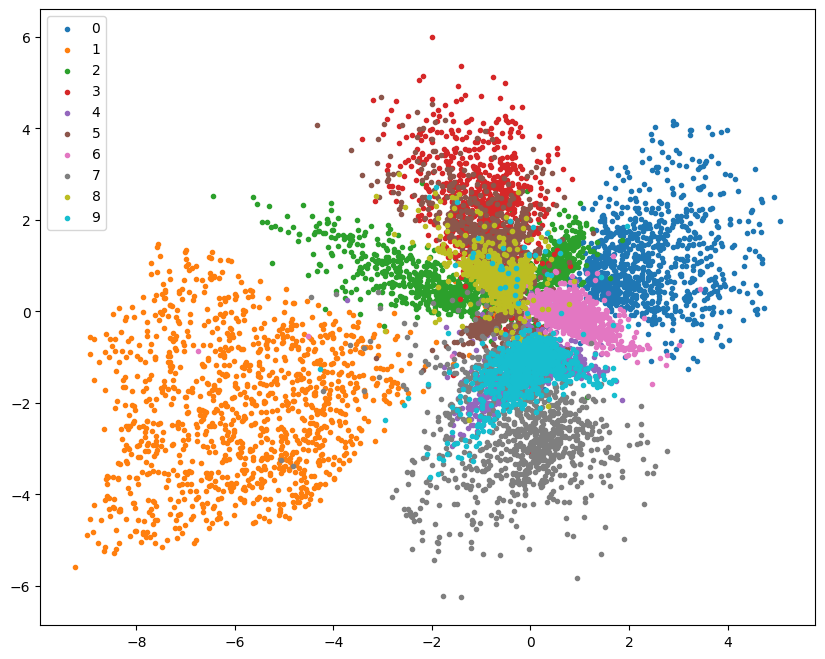

In [ ]:
# エンコード済みのベクトルの値を使ってプロット
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

In [ ]:
# ランダムな潜在変数を生成
N = 16
z = torch.rand((N, 2)) * 8 - 4

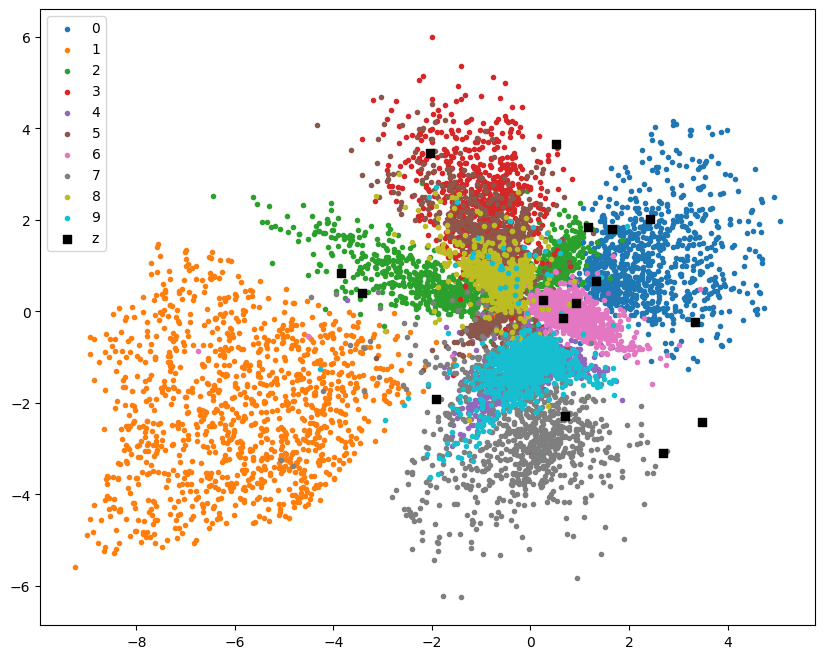

In [ ]:
# ランダムな潜在変数を含めて可視化
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.scatter(z[:, 0], z[:, 1], label="z", marker="s", color="black")
plt.legend()

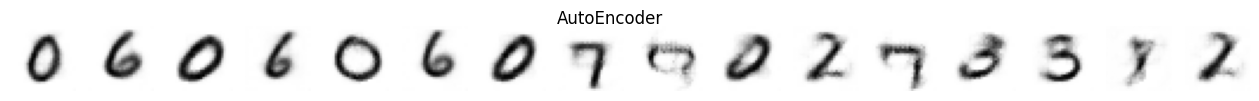

In [ ]:
# 潜在空間からデコーダーで画像生成
ae_decoded = ae_model.decode(z.to(device))
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")

## 変分オートエンコーダ(VAE)

In [44]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channles, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024)
        )

        # 全結合層を定義して平均と対数分散を求める
        self.mu = nn.Linear(1024, latent_dims)
        self.logvar = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = x.reshape(bs, -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return (mu, logvar)

## エンコーダーの分布からのサンプリング

In [45]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # 正規分布のパラメータを取得
        mu, logvar = self.encode(x)

        # 正規分布からサンプリングする
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # 潜在変数をピクセル空間にデコード
        reconstructed = self.decode(z)

        return reconstructed, mu, logvar

    def sample(self, mu, std):
        eps = torch.randn_like(std)
        return mu + eps * std

- 損失関数
$$ D_{KL}\big[N(\mu, \sigma^2) \,\|\, N(0, 1)\big]
= \frac{1}{2} \left( 1 + \log(\sigma^2) -\mu^2 - \sigma^2   \right) $$

In [48]:
# 損失関数の作成
def vae_loss(batch, reconstructed, mu, logvar):
    bs = batch.shape[0]

    # 再構成損失
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none",
    ).sum(dim=-1)

    # KLD
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    # 2つの損失の合計を取り、画像全体で平均を取る
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [50]:
def train_vae(model, num_epochs=10, lr=1e-4):
    model = model.to(device)
    losses = {
        "loss": [],
        "reconstrution_loss": [],
        "kl_loss":[],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
            batch = batch.to(device)

            # モデルに渡して結果を得る
            reconstructed, mu, logvar = model(batch)

            # 損失を計算する
            loss, reconstruction_loss, kl_loss = vae_loss(
                batch, reconstructed, mu, logvar
            )

            # 損失を表示し、描画用に保存
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses["loss"].append(loss.item())
            losses["reconstrution_loss"].append(
                reconstruction_loss.mean().item()
            )
            losses["kl_loss"].append(kl_loss.mean().item())

            # 総損失に基づいてモデルのパラメーターを更新する
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

vae_model = VAE(in_channels=1, latent_dims=2)
losses = train_vae(vae_model, num_epochs=10, lr=1e-4)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

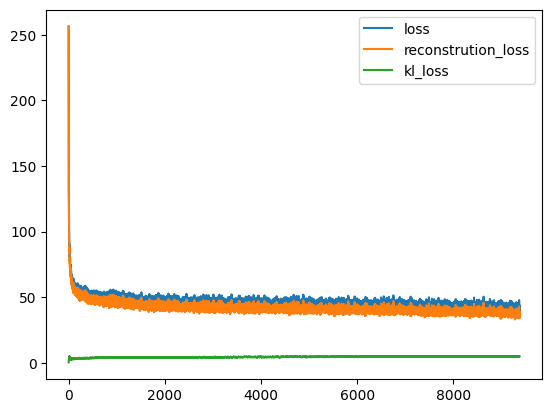

In [51]:
# 訓練中の要素をプロット
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

In [56]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))

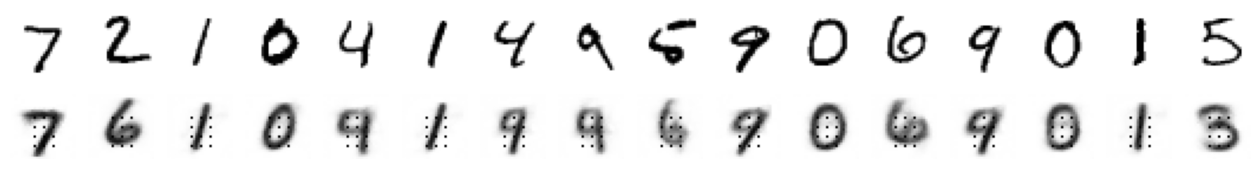

In [60]:
# VAEによる再構成画像の可視化
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

In [61]:
df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(iter(images_labels_dataloader), total=len(images_labels_dataloader)):
    mu, _ = vae_model.encode(batch["image"].to(device))
    mu = mu.to("cpu")

    next_items = {
        "x": [t.item() for t in mu[:, 0]],
        "y": [t.item() for t in mu[:, 1]],
        "label": batch["label"]
    }

    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

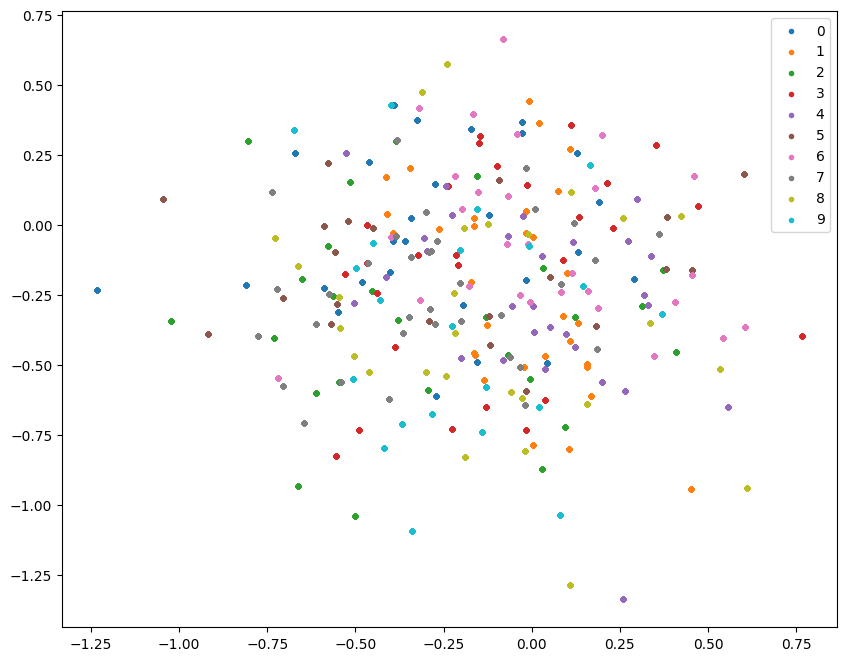

In [62]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend()

In [63]:
z = torch.normal(0, 1, size=(10, 2))
ae_decoded = ae_model.decode(z.to(device))
vae_decoded = vae_model.decode(z.to(device))

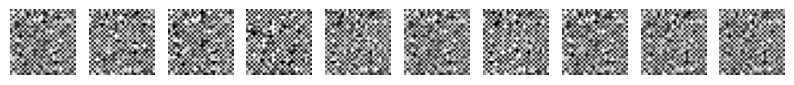

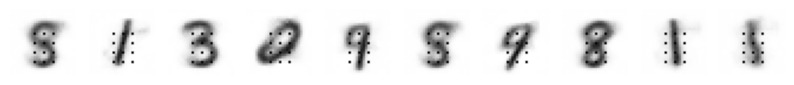

In [69]:
show_images(ae_decoded.cpu(), imsize=1, nrows=1)
show_images(vae_decoded.cpu(), imsize=1, nrows=1)